# Actor-Critic & PPO

In this implementation, we solve a couple issues with vanilla policy gradients.

1. We add a critic to prevent taking below-average actions
2. We prevent policy weight updates from drifting too far by clipping the ratio of probabilities of actions taken (this will make more sense later)

In [46]:
import argparse
from collections import namedtuple
from copy import deepcopy
from itertools import count


import gym
import numpy as np
import ray
import torch
import torch.nn.functional as F
from torch import nn, tensor
from torch.distributions.categorical import Categorical
from torch.nn import Linear
from torch.optim import Adam
from matplotlib import pyplot as plt
gym.logger.set_level(40)

Yes, we're beating a dead horse with CartPole, but it really is useful for prototyping algorithms.

In [2]:
ENV = 'CartPole-v0'

## Hyperparameters

In [31]:
EPSILON = 0.15
GAMMA = .999

## Define Model

A model is a policy and a value function, VF (it's used to compute an advantage later). This VF (the *critic*) penalizes taking below-average value actions since it estimates the average value of all actions.

We could make the policy and VF part of a 2-headed neural network, but we decided to keep this simple and just make them separate networks.

In [32]:
env = gym.make(ENV)

state_size = int(np.prod(env.observation_space.shape))
action_size = int(env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
# Coupling policy and value function didn't help much.
class Policy(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=50):
        super().__init__()

        S, A, H = state_size, action_size, hidden_size

        self.h1 = Linear(S, H)
        self.h2 = Linear(H, H)
        self.out = Linear(H, A)

    def forward(self, s):
        s = F.relu(self.h1(s))
        s = F.relu(self.h2(s))
        s = F.softmax(self.out(s), dim=None)
        p = Categorical(s)
        return p


class VF(nn.Module):
    def __init__(self, state_size, hidden_size=50):
        super().__init__()

        S, H = state_size, hidden_size

        self.h1 = Linear(S, H)
        self.h2 = Linear(H, H)
        self.out = Linear(H, 1)

    def forward(self, s):
        s = F.relu(self.h1(s))
        s = F.relu(self.h2(s))
        return self.out(s)

We just combine the policy and value function in a wrapper class to make things easier later. (This is essentially a tuple.)

In [6]:
class Model:
    def __init__(self, state_size, action_size, hidden_size=50):
        self.policy = Policy(state_size, action_size, hidden_size)
        self.vf = VF(state_size, hidden_size)

    def __call__(self, s):
        return self.policy(s)

## Data gathering

Same as vanilla PG, except for one thing:

We gather data with the old model so we can be sure the new model does not have its weights drift too far in one gradient update.

In [7]:
Rollout = namedtuple("Rollout", ["states", "actions", "rewards"])

In [15]:
def gather_data(old_model):
    """Execute one rollout."""
    env = gym.make(ENV)
    s, done = env.reset(), False

    rollout = Rollout(states=[], actions=[], rewards=[])

    while not done:
        s = torch.from_numpy(s).float()
        p = old_model(s)
        a = p.sample()

        with torch.no_grad():
            succ, r, done, _ = env.step(a.numpy())

        rollout.states.append(s)
        rollout.actions.append(a)
        rollout.rewards.append(r)

        s = succ

    return rollout

## Preventing policy drift

One of the issues with PG is that it can make too large an update in a single round of training and end up taking totally different actions from the previous round, which can ruin the data it gathers. Imagine turning right every day on the way to work and one day, you suddenly turn left. Your observations from that will be totally unlike what you've seen before and your actions will be essentially random since you're in an new and unexplored part of the environment.

We prevent this by basically clipping the new policy. We calculate the probability of actions taken under the old and new policies, and clip if their ratio is too large.

## Training

This implements the basic logic of PPO. 

1. Turn training data into torch tensors and discount the rewards.
2. Update the value function and compute advantages
3. Compute probabilities of actions taken, under old and new policies
4. Get ratio of those probabilities
5. Clip if it improves the loss
6. Backprop total loss and update policy and VF

<img src=https://blog.openai.com/content/images/2017/07/math_PPO_5-1.png>
<em><center> Source: OpenAI </center></em>

In [9]:
def get_discounted_returns(rewards):
    discounted_rewards = [GAMMA**t * r for t, r in enumerate(rewards)]

    cumulative_returns = tensor([
        sum(discounted_rewards[t:]) for t, _ in enumerate(discounted_rewards)
    ])
    
    return cumulative_returns

In [10]:
def train(model, old_model, data) -> float:
    """Statefully trains on batch of data."""
    states, actions, rewards = data

    states = torch.stack(states)
    actions = torch.stack(actions)

    cumulative_returns = get_discounted_returns(rewards)

    state_values = model.vf(states).reshape(-1)
    
    # Compute critic-adjusted returns
    adv = cumulative_returns - state_values
    # Update VF
    vf_loss = F.mse_loss(state_values, cumulative_returns)

    # Old model is copied anyway, so no updates to it are necessary.
    with torch.no_grad():
        log_probs_old = old_model(states).log_prob(actions)
    log_probs_curr = model(states).log_prob(actions)

    ratio = torch.exp(log_probs_curr - log_probs_old)

    policy_loss = torch.min(-(adv * ratio).mean(),
                            -(adv * ratio.clamp(1 - CLIP, 1 + CLIP)).mean())

    loss = policy_loss + vf_loss

    optimizer = Adam(
        list(model.policy.parameters()) + list(model.vf.parameters()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

## Main loop

**Instantiate a Policy**

In [48]:
model = Model(state_size, action_size)
old_model = deepcopy(model)

### Run the Training Loop

In [49]:
running_rewards = []
last_number_of_episodes = 100

for episode in count(1):

    rollouts = [gather_data(old_model) for _ in range(4)]

    for data in rollouts:
        _ = train(model, old_model, data)

    reward = sum(data.rewards)
    average_reward = np.mean(running_rewards[-last_number_of_episodes:])
    last_reward = running_rewards.append(reward)
    
    if episode % 10 == 0:
        print('Episode {}\tLast Reward: {:.2f}\tAverage Reward: {:.2f}'.format(
            episode, reward, average_reward))
    
    if average_reward > env.spec.reward_threshold:
        print("Solved! Average reward is now {} and "
              "the last episode runs to {} time steps!".format(average_reward, reward))
        break
        
    running_rewards.append(reward)
    old_model = deepcopy(model)

/Users/vora-family/Desktop/rl-talk-kdd/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/Users/vora-family/Desktop/rl-talk-kdd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vora-family/Desktop/rl-talk-kdd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 10	Last Reward: 13.00	Average Reward: 17.33
Episode 20	Last Reward: 17.00	Average Reward: 15.79
Episode 30	Last Reward: 32.00	Average Reward: 16.31
Episode 40	Last Reward: 27.00	Average Reward: 17.26
Episode 50	Last Reward: 13.00	Average Reward: 18.24
Episode 60	Last Reward: 32.00	Average Reward: 21.48
Episode 70	Last Reward: 63.00	Average Reward: 26.28
Episode 80	Last Reward: 28.00	Average Reward: 33.90
Episode 90	Last Reward: 58.00	Average Reward: 40.80
Episode 100	Last Reward: 71.00	Average Reward: 46.90
Episode 110	Last Reward: 131.00	Average Reward: 58.04
Episode 120	Last Reward: 76.00	Average Reward: 73.02
Episode 130	Last Reward: 46.00	Average Reward: 89.80
Episode 140	Last Reward: 83.00	Average Reward: 106.48
Episode 150	Last Reward: 185.00	Average Reward: 128.62
Episode 160	Last Reward: 200.00	Average Reward: 138.04
Episode 170	Last Reward: 200.00	Average Reward: 146.96
Episode 180	Last Reward: 200.00	Average Reward: 153.26
Episode 190	Last Reward: 200.00	Average Rewar

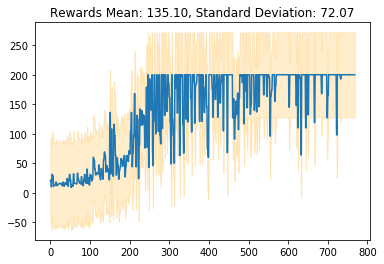

In [50]:
rewards = np.array(running_rewards)
rewards_mean = np.mean(rewards)
rewards_std = np.std(rewards)


plt.plot(running_rewards)
plt.fill_between(
    range(len(rewards)),
    rewards-rewards_std, 
    rewards+rewards_std, 
    color='orange', 
    alpha=0.2
)
plt.title(
    'Rewards Mean: {:.2f}, Standard Deviation: {:.2f}'.format(
        np.mean(running_rewards),
        np.std(running_rewards)
    )
)
plt.show()

**Much better!. What helped...:**

1. PPO Loss Function
2. Having a Critic 
3. Advantage Estimation 